In [1]:
import models
from models import combine_bench_prior, load_priorband_data,add_rel_ranks,rename_algos,create_incumbent, model, create_cd_cluster
import pandas as pd
import numpy as np

algorithm="algorithm";benchmark="bench_prior";seed="seed";time="used_fidelity"
algos=["pb_mutation_dynamic_geometric-default-at-target","random_search","hyperband"]
#fs=[24]
#f_space=np.linspace(1,max(fs),max(fs)).tolist()
benchmarks=["jahs_cifar10","jahs_colorectal_histology","jahs_fashion_mnist","lcbench-126026","lcbench-167190","lcbench-168330","lcbench-168910","lcbench-189906","cifar100_wideresnet_2048","imagenet_resnet_512","lm1b_transformer_2048","translatewmt_xformer_64"]
label_dict={'random_search': 'RS', 'hyperband': 'HB', 'pb_mutation_dynamic_geometric-default-at-target': 'PB', 'jahs_cifar10': 'JAHS-C10', 'jahs_colorectal_histology': 'JAHS-CH', 'jahs_fashion_mnist': 'JAHS-FM', 'lcbench-126026': 'LC-126026', 'lcbench-167190': 'LC-167190', 'lcbench-168330': 'LC-168330', 'lcbench-168910': 'LC-168910', 'lcbench-189906': 'LC-189906', 'cifar100_wideresnet_2048': 'PD1-Cifar100', 'imagenet_resnet_512': 'PD1-ImageNet', 'lm1b_transformer_2048': 'PD1-LM1B', 'translatewmt_xformer_64': 'PD1-WMT',"random_search_prior":"RS+Prior","bo":"BO","pibo":"PiBO","bohb":"BOHB","priorband_bo":"PB+BO"}

data=pd.read_parquet("priorband_benchPrior_relRanks_f24_meta.parquet")
# data=pd.read_parquet("pibo_benchPrior_relRanks_f24_meta.parquet")

In [2]:
from pymer4 import Lmer,Lm
loss="value"
model_lmer = Lm(
    formula=f"{loss}~{algorithm}",
    data=data,
)
factors={algorithm: list(data[algorithm].unique())}
model_lmer.fit(
    factors=factors,
    REML=False,
    summarize=False,
    verbose=False,
)

data["dummy"] = "0"
data.at[data.index[5555],"dummy"] = "1"

model_lm = Lmer(
    formula=f"{loss}~{algorithm}+(1|dummy)",
    data=data,
)
factors={algorithm: list(data[algorithm].unique())}
model_lm.fit(
    factors=factors,
    REML=False,
    summarize=False,
    verbose=False,
)

print(model_lmer.summary(),"\n")
print(model_lm.summary())


boundary (singular) fit: see help('isSingular') 

Formula: value~algorithm

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 86400	 R^2: 0.001	 R^2_adj: 0.001

Log-likelihood: -269924.244 	 AIC: 539854.489	 BIC: 539882.589

Fixed effects:

                 Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val  Sig
Intercept           2.263   2.200    2.327  0.032  86397  69.808  0.000  ***
algorithm[T.PB]     0.293   0.203    0.383  0.046  86397   6.397  0.000  ***
algorithm[T.RS]    -0.100  -0.190   -0.010  0.046  86397  -2.182  0.029    * 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: value~algorithm+(1|dummy)

Family: gaussian	 Inference: parametric

Number of observations: 86400	 Groups: {'dummy': 2.0}

Log-likelihood: -269924.244 	 AIC: 539858.489

Random effects:

                 Name     Var    Std
dummy     (Intercept)   0.000  0.000
Residual               30.276  5.502

No random 

P-values adjusted by tukey method for family of 10 estimates
P-values adjusted by tukey method for family of 10 estimates
P-values adjusted by tukey method for family of 10 estimates
P-values adjusted by tukey method for family of 10 estimates
P-values adjusted by tukey method for family of 10 estimates


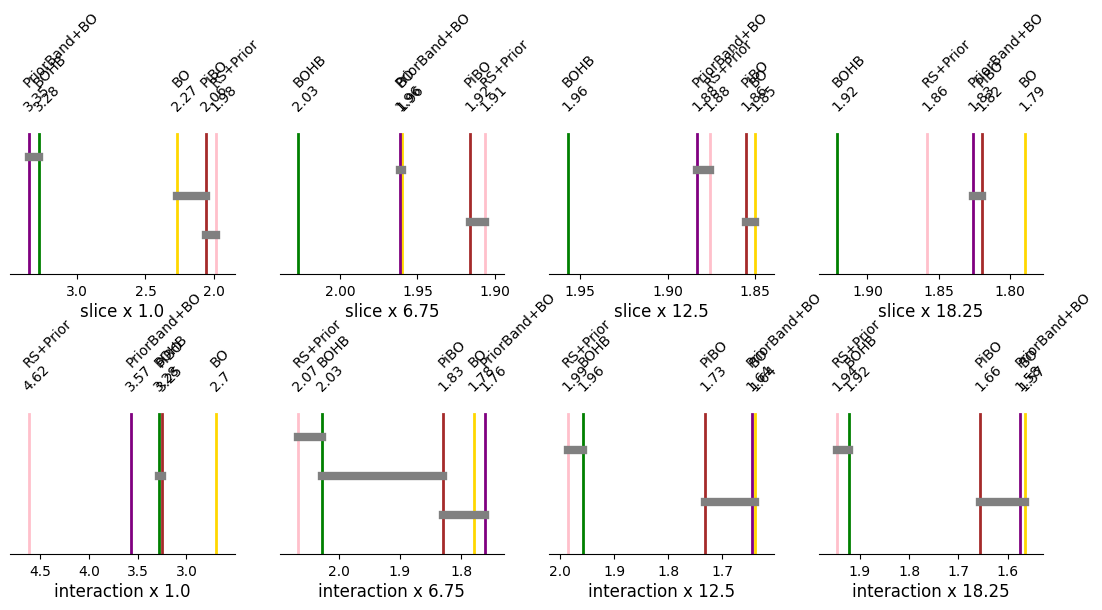

In [ ]:
loss="value"
data_bad=data.loc[data[benchmark].str.contains("at25")]
time_slices=list(np.linspace(1,24,5).round(2))
data_slices=[]
labels=[]
result_cluster={"slice":{}}
for t_n,t in enumerate(time_slices[:-1]):
    labels.append(f"{t}_{time_slices[t_n+1]}")
    data_slices.append(data_bad.loc[(data_bad[time]>=t)&(data_bad[time]<time_slices[t_n+1]+0.1)])
    post_hocs=model(formula=f"{loss}~{algorithm}+(1|{benchmark})",data=data_slices[-1]).post_hoc(marginal_vars=algorithm)
    result_cluster["slice"][t]=post_hocs
data_binned=data
data_binned[f"{time}_bins"] = pd.cut(
            data[time],
            bins=time_slices,
            labels=labels,
            include_lowest=True,
            right=True,
        ).astype(str)
post_hocs=model(formula=f"{loss}~{algorithm}+ {time}_bins + {algorithm}:{time}_bins +(1|{benchmark})",data=data_binned,factor=f"{time}_bins").post_hoc(marginal_vars=algorithm, grouping_vars=f"{time}_bins")
result_cluster["interaction"]={}
for t in labels:
    result_cluster["interaction"][t]=(post_hocs[0].query(f"{time}_bins == '{t}'"),post_hocs[1].query(f"{time}_bins == '{t}'"))
create_cd_cluster(result_cluster)

P-values adjusted by tukey method for family of 10 estimates
P-values adjusted by tukey method for family of 10 estimates
P-values adjusted by tukey method for family of 10 estimates
P-values adjusted by tukey method for family of 10 estimates
P-values adjusted by tukey method for family of 10 estimates


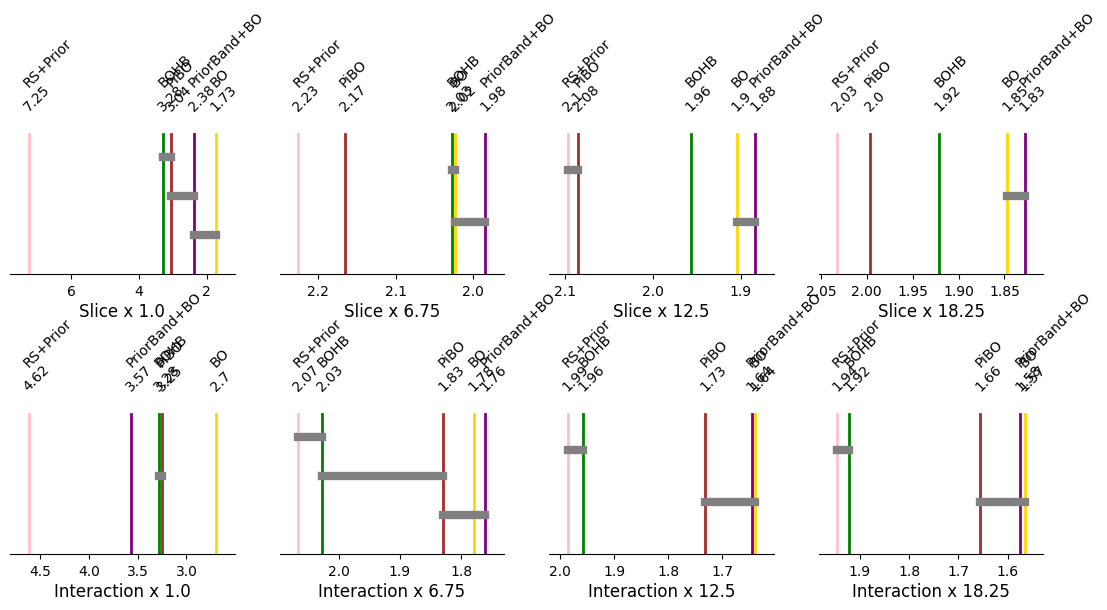

In [ ]:
loss="value"
data_bad=data.loc[data[benchmark].str.contains("bad")]
time_slices=list(np.linspace(1,24,5).round(2))
data_slices=[]
labels=[]
result_cluster={"Slice":{}}
for t_n,t in enumerate(time_slices[:-1]):
    labels.append(f"{t}_{time_slices[t_n+1]}")
    data_slices.append(data_bad.loc[(data_bad[time]>=t)&(data_bad[time]<time_slices[t_n+1]+0.1)])
    post_hocs=model(formula=f"{loss}~{algorithm}+(1|{benchmark})",data=data_slices[-1]).post_hoc(marginal_vars=algorithm)
    result_cluster["Slice"][t]=post_hocs
data_binned=data
data_binned[f"{time}_bins"] = pd.cut(
            data[time],
            bins=time_slices,
            labels=labels,
            include_lowest=True,
            right=True,
        ).astype(str)
post_hocs=model(formula=f"{loss}~{algorithm}+ {time}_bins + {algorithm}:{time}_bins +(1|{benchmark})",data=data_binned,factor=f"{time}_bins").post_hoc(marginal_vars=algorithm, grouping_vars=f"{time}_bins")
result_cluster["Interaction"]={}
for t in labels:
    result_cluster["Interaction"][t]=(post_hocs[0].query(f"{time}_bins == '{t}'"),post_hocs[1].query(f"{time}_bins == '{t}'"))
create_cd_cluster(result_cluster)